In [ ]:
# ------------------------------------------------------------------------------
# Set training variables
# ------------------------------------------------------------------------------

# System level
import sys
import os
if 'thouis' in os.getcwd():
    os.environ['CUDA_VISIBLE_DEVICES'] = '1'
    import tf_memory_limit


# Arrays
import numpy as np

# Keras (www.keras.io)
from keras.models import Sequential, Model
from keras.layers import Input, Flatten, Dense, Activation, Dropout, merge, Concatenate, Maximum, Lambda
from keras.layers import Conv2D, MaxPooling2D, Convolution2D
from keras.layers.normalization import BatchNormalization
from keras.initializers import Constant
from keras.optimizers import SGD, Adam
from keras.models import model_from_json
from keras.utils import np_utils
from keras import backend as K
from keras.callbacks import Callback, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

# Sklearn (for machine learning)
from sklearn import metrics

# Plots
import matplotlib.cm as cm
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline
try:
    import seaborn as sns
except:
    pass

import h5py

In [2]:
from astropy.table import Table

In [4]:
metadata = Table.read('/home/thouis/xorastro/big-data/joined_meta.tsv', format='ascii.tab')
images = h5py.File('/home/thouis/xorastro/big-data/imgcube-uint8-all.h5', 'r')['imgcube']

In [5]:
len(metadata), images.shape

(247590, (424, 424, 247590))

In [6]:
metadata.keys()

['id',
 'dr7objid',
 'project_id',
 'location',
 'classification_count',
 'external_ref',
 'created_at',
 'updated_at',
 'region',
 'redshift_bin',
 'magsize_bin',
 'battle_bin',
 'ra_1',
 'dec_1',
 'stripe82',
 'stripe82_coadd',
 'extra_original',
 'objid',
 'ra_2',
 'dec_2',
 'u',
 'g',
 'r',
 'i',
 'z']

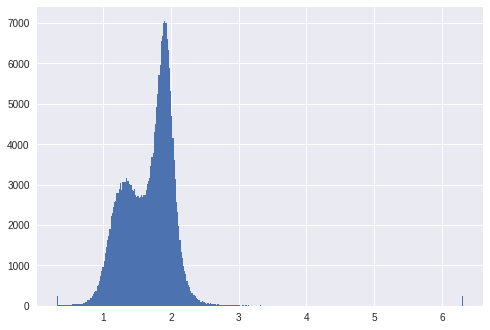

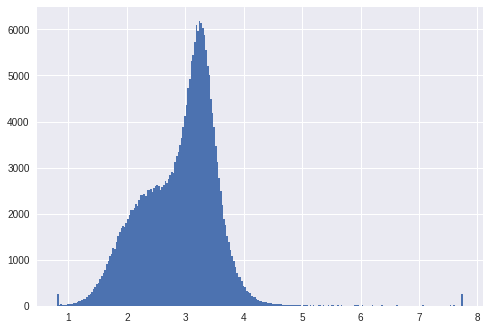

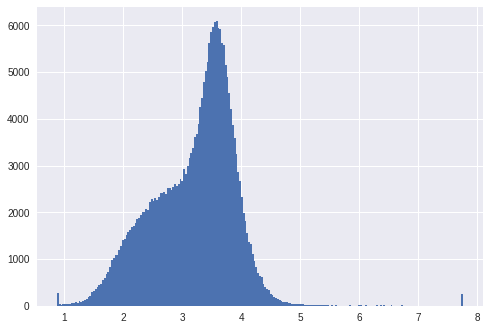

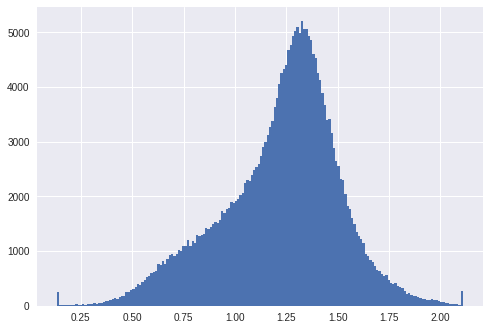

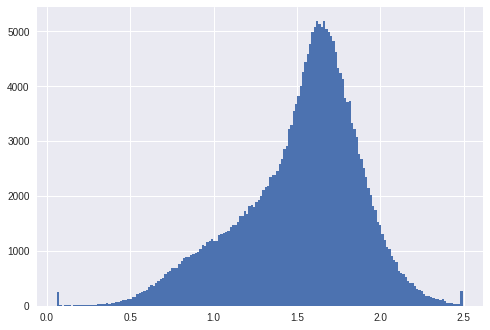

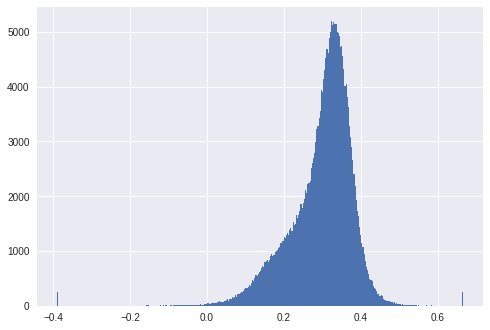

In [11]:
colors = np.array([metadata[:][a] - metadata[:][b] for a, b in 'ug ui uz gi gz iz'.split()]).T
colors.shape

for idx in range(6):
    figure()
    colors[:, idx] = np.clip(colors[:, idx], np.percentile(colors[:, idx], 0.1), np.percentile(colors[:, idx], 99.9))
    hist(colors[:, idx], 'auto')

In [48]:

batch_size = 64

c_train = colors[:int(colors.shape[0] * .8)]
color_mean = c_train.mean(axis=0)
color_std = c_train.std(axis=0)
print(color_mean, color_std)

def datagen(lo, hi, batch_size=batch_size):
    batch_ims = []
    batch_colors = []
    while True:
        for sidx in range(lo, hi - 1024, 1024):
            subset_images = images[..., sidx:sidx + 1024]
            subset_color = colors[sidx:sidx + 1024, :]
            order = np.random.uniform(0, 1, 1024).argsort()
            for idx in order:
                c = subset_color[idx, :]
                batch_colors.append((c - color_mean) / color_std)
                batch_ims.append(subset_images[:, :, idx])
                if len(batch_colors) == batch_size:
                    yield np.stack(batch_ims, axis=0)[..., np.newaxis], np.stack(batch_colors, axis=0)
                    batch_ims = []
                    batch_colors = []

tenth = int(colors.shape[0] * .1)
train_gen = datagen(0, 8 * tenth)
valid_gen = datagen(8 * tenth, 9 * tenth)
test_gen = datagen(9 * tenth, colors.shape[0])
colors.shape

[ 1.67879583  2.90445634  3.20151008  1.22482393  1.52286225  0.29801406] [ 0.40020243  0.64503525  0.70399763  0.28660114  0.35749301  0.08367311]


(247590, 6)

198072 222831
198072
sh (1024, 6) (247590, 6)
(64, 424, 424, 1)
(64, 6)
[-0.2059287  -0.22049338 -0.21170267 -0.20577817 -0.1867813  -0.09289117] [ 0.89425971  1.00350669  1.02887927  1.08636363  1.09726114  1.05521041]


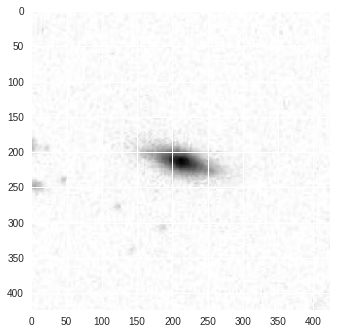

In [39]:
batchims, batchcolors = next(valid_gen)
print(batchims.shape)
print(batchcolors.shape)
imshow(batchims[0, ..., 0])
print(batchcolors.mean(axis=0), batchcolors.std(axis=0))

In [63]:
# ------------------------------------------------------------------------------
# Set up model architecture
# see Figure 4, Figure 8, and Table 2 of Dielemannnnn paper
# ------------------------------------------------------------------------------

# Branch builder
conv00 = Conv2D(filters=32, kernel_size=(6,6), strides=1)
bn00 = BatchNormalization()
conv01 = Conv2D(filters=64, kernel_size=(5,5), strides=1)
bn01 = BatchNormalization()
conv02 = Conv2D(filters=128, kernel_size=(3,3), strides=1)
bn02 = BatchNormalization()
conv03 = Conv2D(filters=128, kernel_size=(3,3), strides=1)
bn03 = BatchNormalization()

# don't use batchnorm for now
bn00 = bn01 = bn02 = bn03 = lambda x: x

def make_branch(x, activation='softplus'):
    def act(v):
        return Activation(activation)(v)
    def pool(v):
        return MaxPooling2D(pool_size=(2, 2))(v)

    c00 = act(bn00(pool(conv00(x))))
    c01 = act(bn01(pool(conv01(c00))))
    c02 = act(bn02(conv02(c01)))
    c03 = act(bn03(pool(conv03(c02))))

    f03 = Flatten()(c03)
    return f03

In [64]:
# Perspective Construction

input_shape = batchims[0].shape

# the image input
image_in = Input(shape=input_shape)

# rotate by 45
rotator = Lambda(lambda x: tf.contrib.image.rotate(image_in, np.pi / 4))
image_45 = rotator(image_in)

# cutout centers
subim_size = 207
input_center = batchims[0].shape[1] // 2
lo = input_center - subim_size // 2
hi = lo + subim_size
cutout = Lambda(lambda x: x[:, lo:hi, lo:hi, :])
subim = cutout(image_in)
subim45 = cutout(image_45)

# downscale 3x3 mean - but allow it to modify the filter
downfilt = Conv2D(filters=1, kernel_size=(3,3), strides=3, kernel_initializer=Constant(1/9), trainable=True)
downsub = downfilt(subim)
downsub45 = downfilt(subim45)

# cut out 4 views from each = 8 views
# tf.image.rot90 would be nice, but it doesn't handle batches of images
view1 = Lambda(lambda x: x[:, :45, :45, :])
view2 = Lambda(lambda x: tf.transpose(x, perm=[0, 2, 1, 3])[:, :, ::-1, :][:, :45, :45, :])
view3 = Lambda(lambda x: x[:, ::-1, ::-1, :][:, :45, :45, :])
view4 = Lambda(lambda x: tf.transpose(x, perm=[0, 2, 1, 3])[:, ::-1, :, :][:, :45, :45, :])
dsviews = [v(downsub) for v in [view1, view2, view3, view4]]
ds45views = [v(downsub45) for v in [view1, view2, view3, view4]]

# transpose each view = 16 views
transposer = Lambda(lambda x: tf.transpose(x, perm=[0, 2, 1, 3]))
transposedviews = [transposer(x) for x in dsviews + ds45views]

if False:
    batchims[0, 211:217, 211:217, 0] = 0
    batchims[0, 205:215, 211:214, 0] = 0

    # debugging - display all the steps and outputs
    m = Model(inputs=[image_in], outputs=[image_in, image_45, subim, subim45, downsub, downsub45] + dsviews + ds45views + transposedviews)
    outs = m.predict_on_batch(batchims)
    for o in outs:
        figure()
        imshow(o[0, ..., 0])
        title(str(o[0, ..., 0].shape))


allviews = dsviews + ds45views + transposedviews

In [65]:
# now set up the 16-way branching
merge = Maximum()
branches = [make_branch(x) for x in allviews]
merged_outputs = merge(branches)

# Dense layers
mergedrop = Dropout(0.5)(merged_outputs)
d0 = Dropout(0.5)((Dense(512, activation='relu')(mergedrop)))
d1 = Dropout(0.5)((Dense(512, activation='relu')(d0)))

#output layer
last_dense = Dense(6)
y = last_dense(d1)

model = Model(inputs=[image_in], outputs=[y])

# Seems to work better with Adam for me, but SGD+momentum is probably just as good when tuned.
# optimizer = SGD(lr=0.001, momentum=0.9, decay=1e-5)
optimizer = Adam(decay=1e-5)

loss = 'mean_absolute_error'  # MSE was giving me stability issues during training
model.compile(loss=loss, optimizer=optimizer, metrics=['mean_squared_error'])
# model.summary()

In [ ]:
num_batch_train = int(colors.shape[0] * 0.8 / batch_size)
num_batch_valid = int(colors.shape[0] * 0.1 / batch_size)

checkpointer = ModelCheckpoint(filepath='all_diffs.model.{epoch:02d}-{val_loss:.2f}.hdf5', verbose=1, save_best_only=True)

hist = model.fit_generator(train_gen, epochs=10, steps_per_epoch=num_batch_train, validation_data=valid_gen, validation_steps=num_batch_valid, verbose=2, callbacks=[checkpointer])

Epoch 1/10
Epoch 00000: val_loss improved from inf to 0.45208, saving model to all_diffs.model.00-0.45.hdf5
932s - loss: 0.4288 - mean_squared_error: 0.4422 - val_loss: 0.4521 - val_mean_squared_error: 0.4568
Epoch 2/10


In [69]:
cc_valid = [next(valid_gen) for idx in range(num_batch_valid)]
cc_valid, cc_true = zip(*cc_valid)
len(cc_valid), cc_valid[0].shape

(386, (64, 424, 424, 1))

In [85]:
preds = [model.predict_on_batch(p) for p in cc_valid]
preds = np.concatenate(preds, axis=0)
trues = np.concatenate(cc_true)

In [86]:
preds.shape, trues.shape

((24704, 6), (24704, 6))

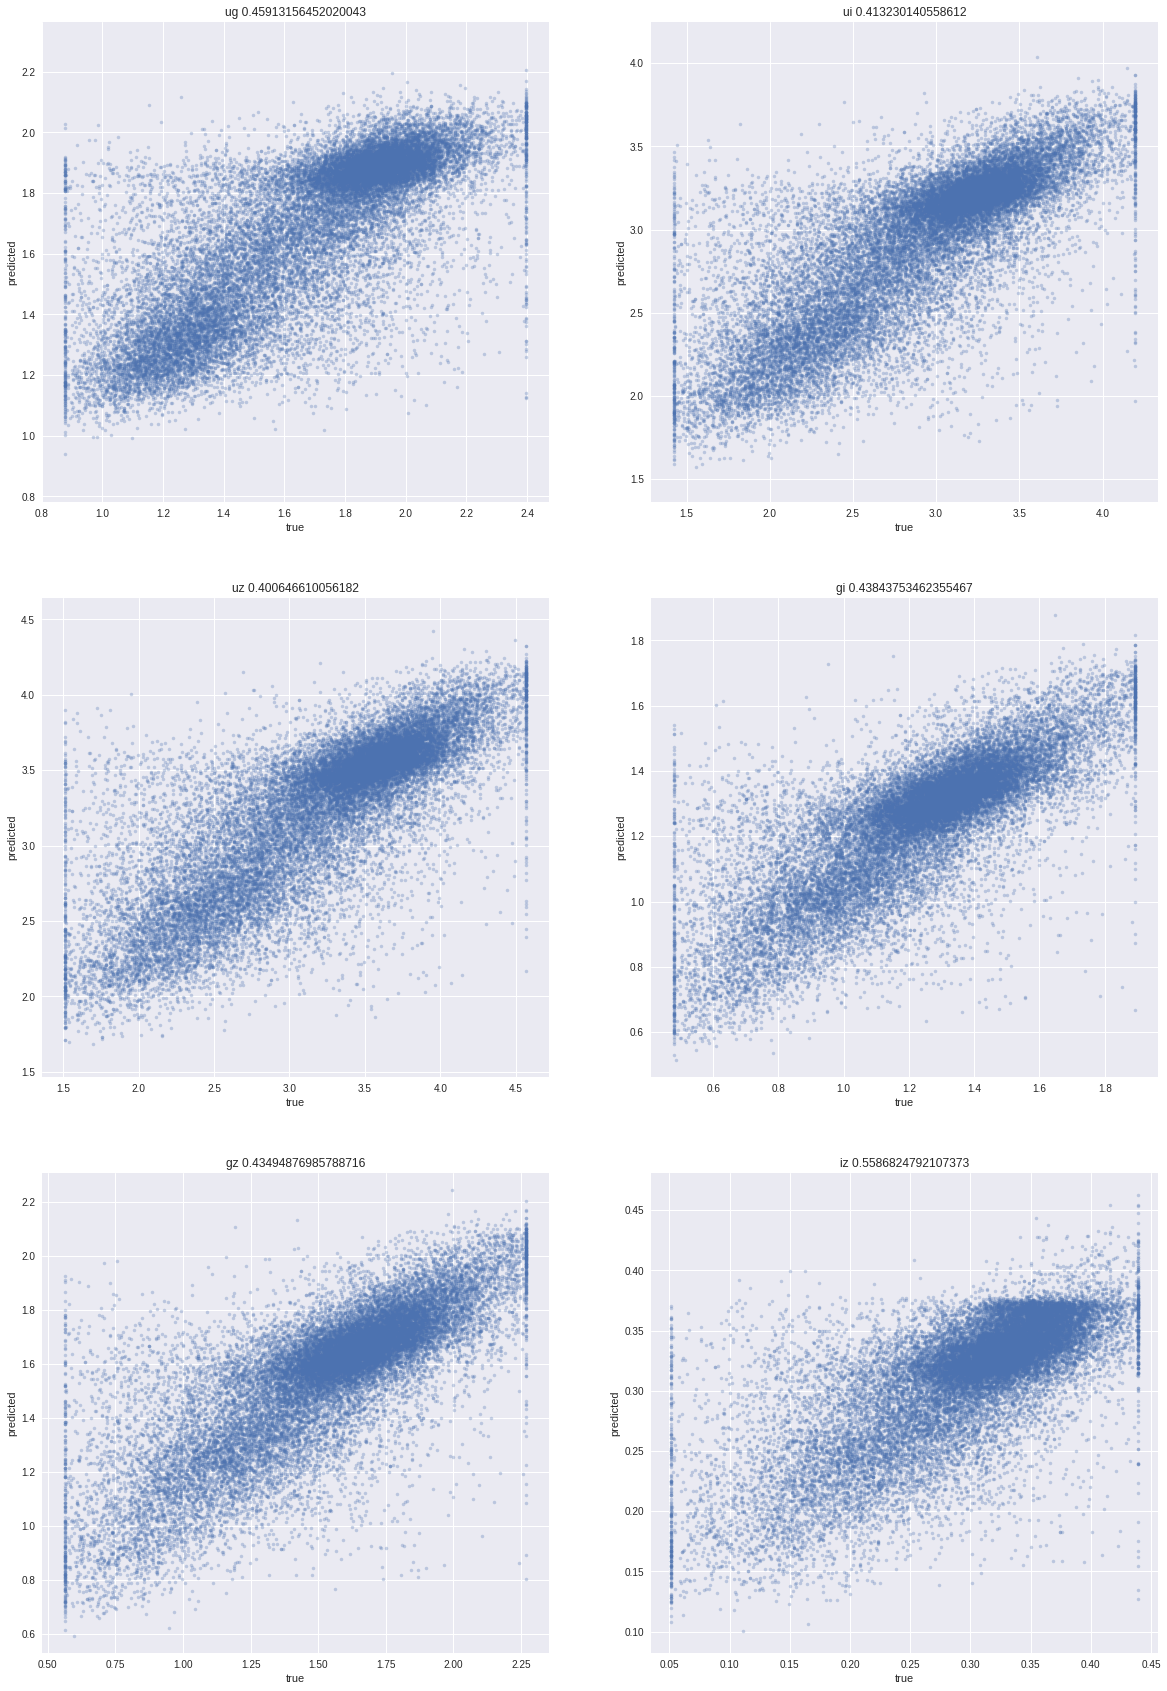

In [87]:
figure(figsize=(20, 30))
for idx in range(6):
    subplot(3, 2, idx + 1)
    t = trues[:, idx]
    t = np.clip(t, np.percentile(t, 1), np.percentile(t, 99))
    plot(t * color_std[idx] + color_mean[idx], preds[:, idx] * color_std[idx] + color_mean[idx], '.', alpha=0.3)
    xlabel('true')
    ylabel('predicted')
    title('{} {}'.format('ug ui uz gi gz iz'.split()[idx], ((trues[:, idx] - preds[:, idx])**2).mean()))
    axis('equal')
    

In [88]:
for idx in range(6):
    true_error = (((trues[:, idx] - preds[:, idx]) * color_std[idx])**2).mean()
    print('ug ui uz gi gz iz'.split()[idx], true_error, sqrt(true_error))

ug 0.073535422328 0.271174154978
ui 0.171932859761 0.41464787442
uz 0.19856553268 0.445606926203
gi 0.036013352765 0.189771843973
gz 0.0555869986803 0.235768951901
iz 0.00391144136462 0.0625415171276


In [33]:
print("True sigma, adjusted", sqrt(true_error) / 3.676)

True sigma, adjusted 0.121029428617


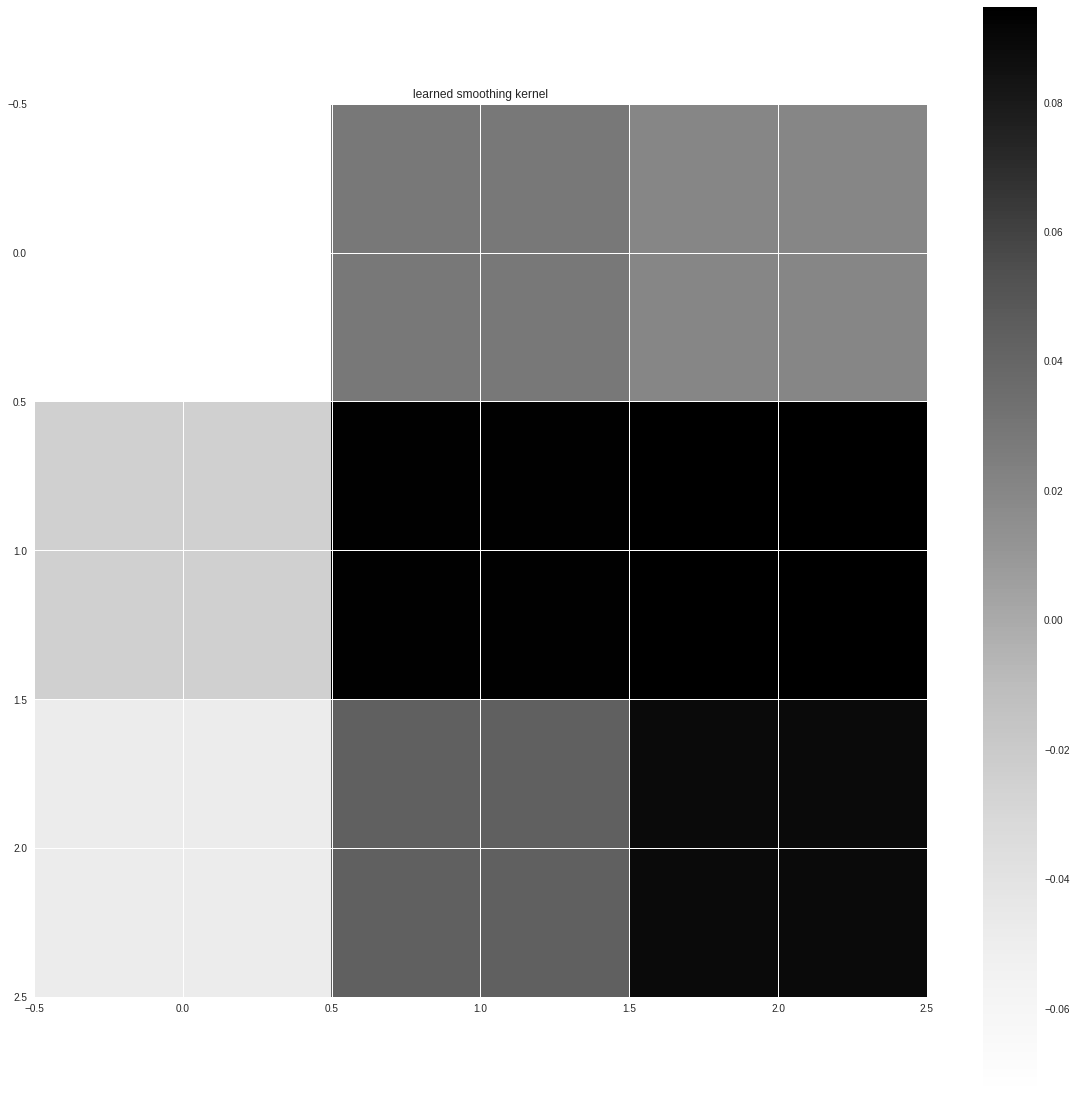

In [34]:
imshow(K.get_value(downfilt.kernel).reshape(3, 3))
colorbar()
title('learned smoothing kernel')

In [ ]:
plot(trues, preds, '.', alpha=0.3)


In [ ]:
# cc_valid = np.concatenate(cc_valid)

lo_mask = (trues < 0) & (trues > -.5) & (preds < -.5) & (preds > -1.5)
hi_mask = (trues < 0) & (trues > -.5) & (preds < 11) & (preds > .5)
loidx = np.nonzero(lo_mask)[0]
hi_idx = np.nonzero(hi_mask)[0]
subidx = 1
figure(figsize=(20,40))
for idx in loidx[-16:]:
    subplot(8, 4, subidx)
    imshow(cc_valid[idx, ..., 0])
    title('lo')
    xticks([]); yticks([])
    subidx += 1
for idx in hi_idx[-16:]:
    subplot(8, 4, subidx)
    imshow(cc_valid[idx, ..., 0])
    xticks([]); yticks([])
    title('hi')
    subidx += 1




In [23]:
ordered_preds = []
for idx in range(int(len(color) * .8), int(len(color) * .9), batch_size):
    b = np.transpose(images[..., idx:idx+batch_size], [2, 0, 1])[..., np.newaxis]
    ordered_preds.append(model.predict_on_batch(b))
ordered_preds = np.concatenate(ordered_preds)
ordered_preds.shape

(24768, 1)

In [24]:
lo = int(len(color) * .8)
hi = lo + ordered_preds.shape[0]
subtable = metadata[lo:hi].copy()
subtable['predicted'] = color_mean + color_std * ordered_preds.ravel()
subtable['true_gi'] = color[lo:hi]
subtable.info

<Table length=24768>
        name          dtype 
-------------------- -------
                  id   int64
            dr7objid   int64
          project_id   int64
            location   str45
classification_count   int64
        external_ref   str77
          created_at   str19
          updated_at   str19
              region   int64
        redshift_bin   int64
         magsize_bin   int64
          battle_bin   int64
                ra_1 float64
               dec_1 float64
            stripe82   int64
      stripe82_coadd   int64
      extra_original   int64
               objid   int64
                ra_2 float64
               dec_2 float64
                   u float64
                   g float64
                   r float64
                   i float64
                   z float64
           predicted float32
             true_gi float64

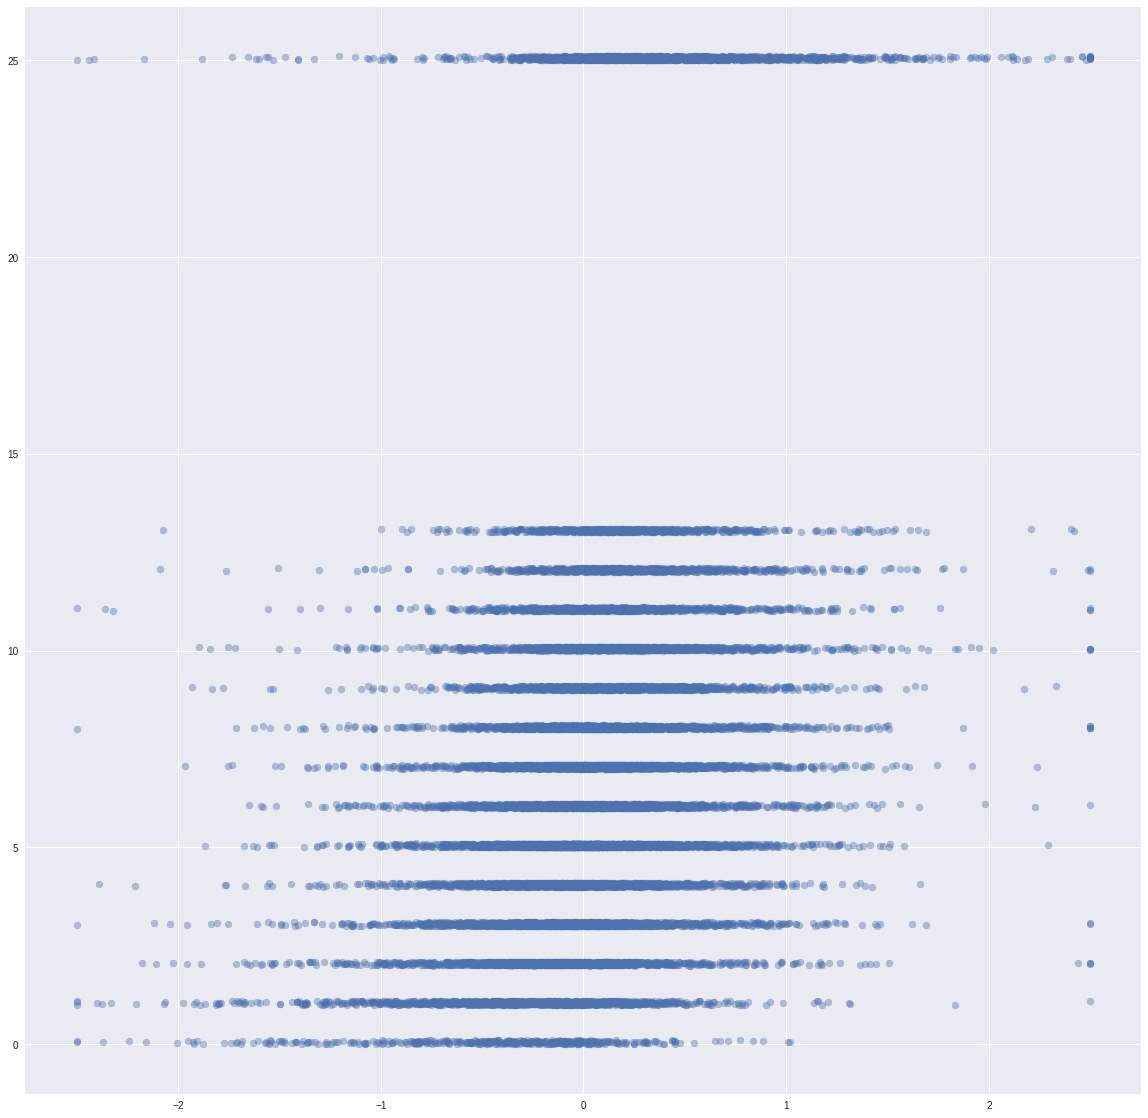

In [25]:
figure(figsize(20,20))
scatter(np.clip(subtable[:]['true_gi'] - subtable[:]['predicted'], -2.5, 2.5),
np.clip(subtable[:]['redshift_bin'], 0, 25) + np.random.uniform(0, 0.1, hi - lo), alpha=0.4)

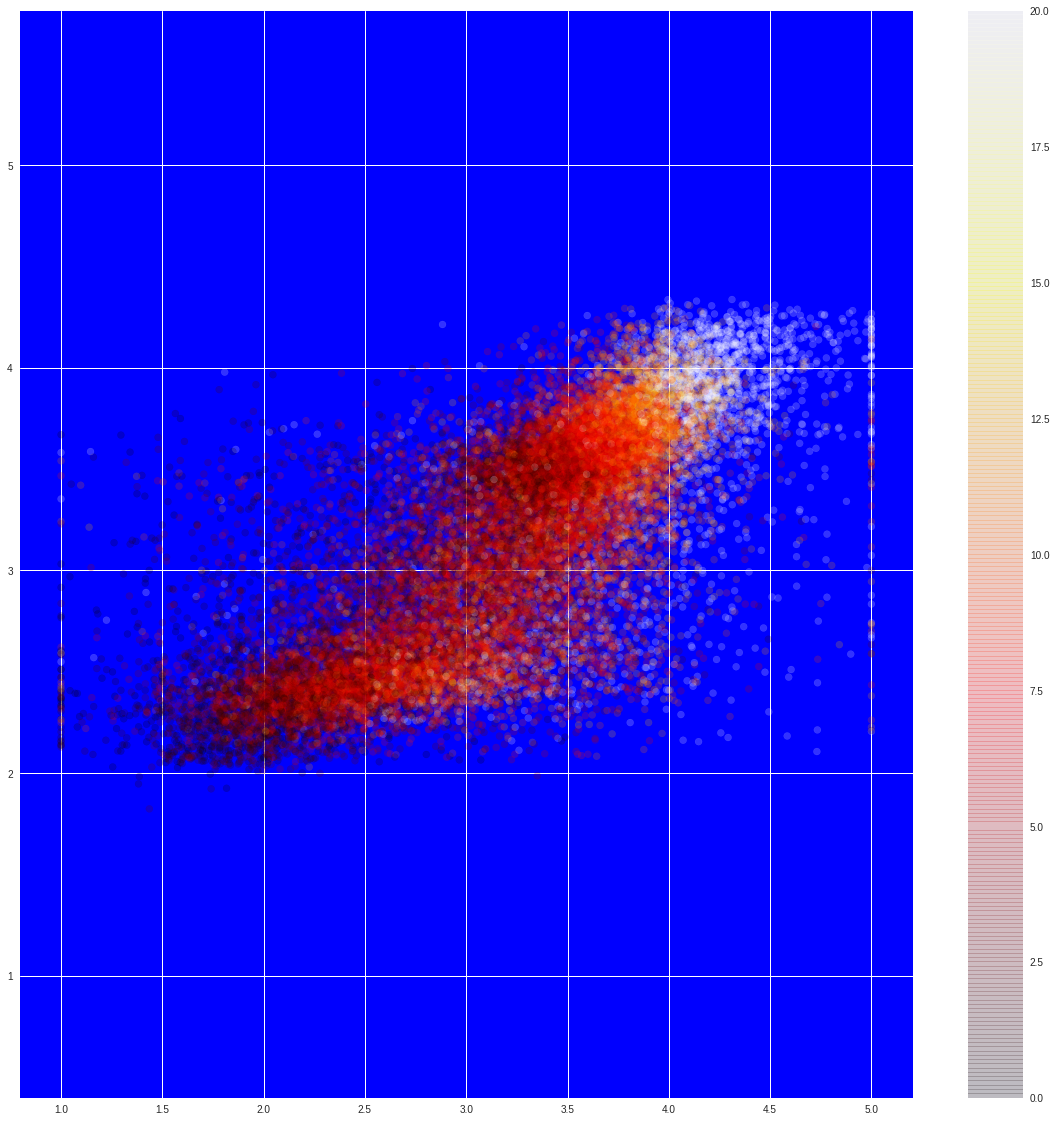

In [28]:
scatter(np.clip(subtable[:]['u'] - subtable[:]['z'], lo_thresh, hi_thresh), subtable[:]['predicted'], c=np.clip(subtable[:]['redshift_bin'], 0, 20), alpha=0.2, cmap='hot')
axis('equal')
colorbar()
gca().set_facecolor('blue')


In [27]:
plot(trues * color_std + color_mean, preds * color_std + color_mean, '.', alpha=0.3)

axis('equal')

NameError: name 'trues' is not defined

In [ ]:
lo_thresh, hi_thresh

In [ ]:
subtable.write("validation_with_predictions_2017_11_30.csv")

In [ ]:
subtable[:5]['g'] - subtable[:5]['i']


In [ ]:
subtable[:5]['true_gi']

In [ ]:
lo_mask = metadata[:]['redshift_bin'] <= 5
hi_mask = (metadata[:]['redshift_bin'] > 10) & (metadata[:]['redshift_bin'] < 20)
loidx = np.nonzero(lo_mask)[0]
hi_idx = np.nonzero(hi_mask)[0]
subidx = 1
figure(figsize=(20,40))
for idx in loidx[:16]:
    subplot(8, 4, subidx)
    imshow(images[..., idx])
    title('lo')
    xticks([]); yticks([])
    subidx += 1
for idx in hi_idx[:16]:
    subplot(8, 4, subidx)
    imshow(images[..., idx])
    xticks([]); yticks([])
    title('hi')
    subidx += 1



In [ ]:
idx

In [ ]:
metadata[idx]

In [78]:
hist.history

{'loss': [0.55470367248935248,
  0.4956203939919327,
  0.48077333348176521,
  0.47251698346814575,
  0.46506042177436735,
  0.46081391378572545,
  0.45660279440779644,
  0.45484011543706376,
  0.45160578595836776,
  0.44863013236385513],
 'mean_squared_error': [0.65340253697261552,
  0.54587118362293907,
  0.52342743457866314,
  0.5102255818299809,
  0.49839601071422612,
  0.49226709810201785,
  0.48596519799138471,
  0.48336990993486811,
  0.47930296216191365,
  0.4743746787059207],
 'val_loss': [0.53950533680038748,
  0.51290705275041448,
  0.47738354255498383,
  0.4688485868545394,
  0.46932045490012886,
  0.46434422678898035,
  0.47001304357780693,
  0.46516408628441508,
  0.45030597871449329,
  0.45188664772349935],
 'val_mean_squared_error': [0.61603603678046115,
  0.56532322719615979,
  0.48964120270057043,
  0.47726625030368103,
  0.47574417601904101,
  0.46833572513544497,
  0.48628071104924298,
  0.47379080256341033,
  0.45106434602039464,
  0.45633703898734995]}

In [84]:
hist.history

{'loss': [0.44555093191983086,
  0.44439236184012604,
  0.44180513017780176,
  0.4399028293302002,
  0.43795522815308885,
  0.43670307082481052,
  0.4348981374586946,
  0.43398612975573342,
  0.43195857691356421,
  0.43052685329162005],
 'mean_squared_error': [0.47580195595429031,
  0.46770405264375053,
  0.46365400554483449,
  0.46050075902985849,
  0.45726973362117718,
  0.45493221241058501,
  0.45208676435828749,
  0.45117566347815719,
  0.44787985975020306,
  0.44626408313059701],
 'val_loss': [0.45705470720721031,
  0.4414137348609885,
  0.44898789078769291,
  0.43927964969620187,
  0.44158486311608647,
  0.43940782330814421,
  0.43910123948297353,
  0.44674673043384455,
  0.44822290277234011,
  0.44952613763858618],
 'val_mean_squared_error': [0.4643494484106494,
  0.44267645852707826,
  0.46121256481952616,
  0.43497418118109976,
  0.43967841376449163,
  0.436524466220579,
  0.43247150317066074,
  0.44597433380049128,
  0.45054290304684269,
  0.45055850579794204]}